# Navigation Project
Written by Finley Marshall \
Supervisor Philipp Wacker


# Kalman Filters
The Kalman Filter combines noisy sensor data and a prior belief of the system to estimate the current state of the system. The Kalman Filter estimate of the system is often more accurate than just the measurements. The Filter only needs to store the last state, so requires very little memory. This project will focus on using Kalman Filters to improve the navigation systems of different vehicles.

## Notation
$x_{n}$: The state of the model at time n\
$\hat{x}_{k|n}$: The state estimate at time k, given observations up to time n\
$\boldsymbol{P}_{n}$: The covariance of the state

$\boldsymbol{F}_{n}$: The state transition model

$\boldsymbol{B}_{n}$: The control input model\
$u_{n}$: The control vector

$w_{n}$: The process noise. $w_{n} \sim { \mathcal{N}}(0, Q_{n})$\
$\boldsymbol{Q}_{n}$: The covariance of process noise

$z_{n}$: The observation of the state

$\boldsymbol{H}_{n}$: The observation model\
$v_{n}$: The observation noise. $v_{n} \sim { \mathcal{N}}(0, R_{n})$\
$\boldsymbol{R}_{n}$: The covariance of observations

# Standard Kalman Filter

The current state can be calculated from the last state, the controls and process noise.\
$x_{n} = \boldsymbol{F}_{n}x_{n-1} + \boldsymbol{B}_{n}u_{n} + w_{n}$

The observation of the state can be calculated from the current state and observation noise.\
$z_{n} = \boldsymbol{H}_{n}x_{n}+ v_{n}$

## Predict the next State
Prior of the state\
$\hat{x}_{n|n-1} = \boldsymbol{F}_{n}\hat{x}_{n-1|n-1} + \boldsymbol{B}_{n}u_{n}$

Priori covariance\
$\boldsymbol{P}_{n|n-1} = \boldsymbol{F}_{n}\boldsymbol{P}_{n-1|n-1}\boldsymbol{F}_{n}^{\mathsf{T}} + \boldsymbol{Q}_{n}$

## Update the State given a Measurement

Innovation pre-fit Residual\
$\tilde{y}_{k} = z_{n} - \boldsymbol{H}_{n}\hat{x}_{n|n-1}$

Innovation Covariance\
$\boldsymbol{S}_{n} =  \boldsymbol{H}_{n}\boldsymbol{P}_{n|n-1}\boldsymbol{H}_{n}^{\mathsf{T}} + \boldsymbol{R}_{n}$

Kalman gain\
$\boldsymbol{K}_{n} = \boldsymbol{P}_{n|n-1}\boldsymbol{H}_{n}^{\mathsf{T}}\boldsymbol{S}_{n}^{-1}$

State estimate\
$\hat{x}_{n|n} = \hat{x}_{n|n-1} + \boldsymbol{K}_{n}\tilde{y}_{n}$

Estimate Covariance\
$\boldsymbol{P}_{n|n} = (\boldsymbol{I} - \boldsymbol{K}_{n} \boldsymbol{H}_{n}) \boldsymbol{P}_{n|n-1}$


The following libraries will be used in this project.

In [309]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, radians, pi, sqrt
from helper_functions import *

# Satellite Navigation
The first example will be a satellite orbiting earth, moving in two dimensions $x_{1}$ and $x_{2}$. \
Model a Satellite that has an anticlockwise orbit, centered at $(0,0)$, with a start radius. \
The satellite randomly moves from unknown causes, that are drawn from a gaussian distribution with variance $Q_{t}$ at time t.\
This will cause the satellite's radius to change over time. \
Can inaccurately measure the distance to the satellite in the $x_{1}$ dimension, want to accurately estimate the $x_{1}$, $x_{2}$ dimensions. \
The measurements of $x_{1}$ are gaussian distributed, with variance $R_{t}$ at time t. \
$a$ is the angle changed every time step, it is constant for this example and know to the model. \



### Control input model, $\boldsymbol{B}_{n}$ and Control vector, $u_{n}$
The satellite does not have controls therefore, 
\begin{align} 
\boldsymbol{B}_{n} &= 0 \\
\\
u_{n} &= 0
\end{align}


### Initial estimate, $\boldsymbol{X}_{0}$ and Initial covariance, $\boldsymbol{Q}_{0}$
The model starts with no prior information about the satellite position. \
The initial estimate is thus $(0,0)$ with a covariance of the radius. 
\begin{align} 
\boldsymbol{X}_{0} &= \begin{pmatrix} 0 \\ 0 \end{pmatrix} \\
\\
\boldsymbol{Q}_{0} &= \begin{pmatrix} radius & 0 \\ 0 & radius \end{pmatrix}
\end{align}

### State transition model, $\boldsymbol{F}_{n}$

The following equation comes from rotating the 2d plane by $a$ radians anti-clockwise.

\begin{align}
\boldsymbol{X}_{t+1} &= \begin{pmatrix} x_{1}(t+1) \\ x_{2}(t+1) \end{pmatrix} \\
 &= \begin{pmatrix} cos(at) & sin(at) \\ sin(at) & -cos(at) \end{pmatrix} \begin{pmatrix} x_{1}(t) \\ x_{2}(t) \end{pmatrix}
\end{align}


Taking derivatives gives
\begin{align}
\boldsymbol{\dot{X}}_{t} &= \begin{pmatrix} \dot{x}_{1}(t) \\ \dot{x}_{2}(t) \end{pmatrix} \\
 &= \begin{pmatrix} 0 & -a \\ a & 0\end{pmatrix} \begin{pmatrix} x_{1}(t) \\ x_{2}(t) \end{pmatrix} \\
 &= \begin{pmatrix} 0 & -a \\ a & 0\end{pmatrix} \boldsymbol{X}_{t}
\end{align}


Using Euler method
\begin{align}
h &= t_{n+1} - t_{n} \\
\boldsymbol{X}_{t+1} &= \boldsymbol{X}_{t}+h\boldsymbol{\dot{X}}_{t} + w_{n}
\end{align}


Subbing $\boldsymbol{\dot{X}}_{t}$ in

\begin{align}
\boldsymbol{X}_{t+1} &= \boldsymbol{X}_{t} + \begin{pmatrix} 0 & -a \\ a & 0 \end{pmatrix}\boldsymbol{X}_{t}h + w_{n} \\
  &= \begin{pmatrix} 1 & -ha \\ ha & 1 \end{pmatrix}\boldsymbol{X}_{t} + w_{n}
\end{align}

Thus,
$$
\boldsymbol{F}_{n} = \begin{pmatrix} 1 & -ha \\ ha & 1 \end{pmatrix}
$$



### Observation model, $\boldsymbol{H}_t$
The satellite measures its $x_1$ dimension. So,
$$z_n = x_1 + v_n$$
Using the standard Kalman Filter equation for $z_n$
$$z_{n} = \boldsymbol{H}_{n}x_{n}+ v_{n}$$
Subbing in $z_n $
$$x_1 + v_n = \boldsymbol{H}_{n}\begin{pmatrix} x_{1} \\ x_{2} \end{pmatrix} + v_n $$
Thus, 
$$ \boldsymbol{H}_t = \begin{pmatrix} 1 & 0 \end{pmatrix}$$

### Covariance of the process noise
Set the variance of the satellite movement to $q$ 
The satellite is not moving randomly very much, so $q$ will be quite small. In practice, this value would be obtained from research about the satellite. What is causing the random movements, other satellites and past movements could all give insight into the value for $q$. Once q is obtained 
$$\boldsymbol{Q}_t = \begin{pmatrix} q & 0 \\ 0 & q \end{pmatrix}$$

### Covariance of the observations
Set the covariance of the satellite movement to $r$.
In practice, r can be obtained from extensive testing of the equipment used to observe the $x_1$ measurements. The manufacturer of the equipment could also supply the expected performance and variances in different conditions. Once $r$ is obtained 
$$\boldsymbol{R}_t = \begin{pmatrix} r \end{pmatrix}$$

It is as much an art as science in choosing what values to use for $r$ and $q$ to get the best result for the model in the real world.

### Satellite object
Create a satellite \
The $x_1$ and $x_2$ true values are stored in $self.x1$ and $self.x2$ respectively. 
The model receives $z_n = x_1 + v_n$.
$self.x1, self.x2, self.times, self.measurements times, self.measurements$

In [310]:
class Satellite:
    def __init__(self, a=1, h=1, q=0, r=0, radius=10, start_angle=None):
        self.a = a
        self.h = h
        self.radius = radius
        self.r = r
        self.q = q
        self.x1 = []
        self.x2 = []
        self.times = []
        self.measurements_times = []
        self.current_time = 0
        self.start_angle = start_angle 
        #The start angle is from the $x_1$ positive axis, anti-clockwise
        self.measurements = []

    def __random_start__(self):
        #returns a random start cords for both x1 and x2
        #if the start angle is not given
        if self.start_angle is None:
            self.start_angle = np.random.uniform(2 * pi)

        x1_cord = self.radius * cos(self.start_angle)
        x2_cord = self.radius * sin(self.start_angle)
        return x1_cord, x2_cord

    def next_cord(self, receive=True):
        self.times.append(self.current_time)

        if len(self.x1) == 0:
            x1_cord, x2_cord = self.__random_start__()
            self.x1.append(x1_cord)
            self.x2.append(x2_cord)

            x1_measurement = x1_cord + np.random.normal(0, self.r)
            self.measurements.append(x1_measurement)
            self.measurements_times.append(self.current_time)

            self.current_time += self.h
            return x1_measurement

        trans_matrix = np.array([[cos(self.a * self.h), -sin(self.a * self.h)],
                                 [sin(self.a * self.h), cos(self.a * self.h)]])
        last_cords = np.array([self.x1[-1], self.x2[-1]])

        x1_cord, x2_cord = np.dot(trans_matrix, last_cords)
        x1_noise, x2_noise = np.random.normal(0, self.q, 2)
        x1_cord += x1_noise
        x2_cord += x2_noise

        self.x1.append(x1_cord)
        self.x2.append(x2_cord)

        if receive:
            x1_measurement = x1_cord + np.random.normal(0, self.r)
            self.measurements.append(x1_measurement)
            self.measurements_times.append(self.current_time)
        else:
            x1_measurement = None

        self.current_time += self.h
        return x1_measurement if receive else None

    def graph(self, show=True):
        #graphs x1, x2 true cords and the measurements of x1
        plt.title('Dimensions X1, X2 and X2 measurements of the satellite over time')
        plt.plot(self.measurements_times, self.measurements, '.', label='Measurements')
        plt.plot(self.times, self.x1, label='x1')
        plt.plot(self.times, self.x2, label='x2')
        if show:
            plt.legend(loc='upper left')
            plt.show()

### Kalman Filter object
Create the Kalman Filter
This is the same notation described in the notation section, without the subscript for time.

In [311]:
class KalmanFilter(object):
    def __init__(self, f, h, q, r, p, x, b=0, u=0):
        self.f = f
        self.h = h
        self.q = q
        self.r = r
        self.p = p
        self.x = x
        self.b = b
        self.u = u
        self.n = f.shape[1]

    def predict(self):
        self.x = np.dot(self.f, self.x) + np.dot(self.b, self.u)
        self.p = np.dot(np.dot(self.f, self.p), self.f.T) + self.q
        return self.x

    def update(self, z):
        y = z - np.dot(self.h, self.x)
        s = np.dot(np.dot(self.h, self.p), self.h.T) + self.r
        k = np.dot(np.dot(self.p, self.h.T), np.linalg.inv(s))
        self.x = self.x + np.dot(k,y)
        self.p = np.dot(np.identity(len(self.x)) - np.dot(k, self.h), self.p)
        return self.x

### Average Error
To calculate the average error of the estimates and graph it, need to calculate the average error at each time step. \
Have the average form the last time step, so will use this to save computation.

\begin{align}
 \bar{x}_{n} &=  \frac{\displaystyle \sum_{i=1}^{n}x_{i}}{n} \\
 &= \frac{\displaystyle \sum_{i=1}^{n-1}x_{i}}{n} + \frac{x_{n}}{n} \\
 &= \frac{n-1}{n}\frac{\displaystyle \sum_{i=1}^{n-1}x_{i}}{n-1} + \frac{x_{n}}{n} \\
 &= \frac{1}{n}((n-1)\bar{x}_{n-1}+x_{n}) 
\end{align}

In [312]:
def average(x, n, a):
    #computes an average from last average a and n indexed at 0 for next item x
    return (n * a + x) / (n + 1)

In [313]:
h = 10
a = (pi * 2) / 360
r = 2
q = 0.1
radius = 10
revolutions = 3
receive_function = always_true

In [314]:
def satellite_example(h, a, r, q, radius, revolutions, receive_function, start_angle=None):

    loop_count = loop_size(h, a, revolutions)

    X = np.array([0,0])
    F = np.array([[1, -a * h], [h * a, 1]])
    H = np.array([1, 0]).reshape(1, 2)
    Q = np.array([[q, 0], [0, q]])
    R = np.array([r])
    P = np.array([[radius, 0], [0, radius]])

    kf = KalmanFilter(f=F, h=H, q=Q, r=R, x=X, p=P)
    satellite = Satellite(a=a, h=h, q=q, r=r, radius=radius, start_angle=start_angle)

    prediction_data = []
    estimate_data = []

    for i in range(loop_count):
        receive = receive_function(i)

        z = satellite.next_cord(receive=receive)

        x1, x2 = kf.predict()
        prediction_data.append((x1, x2, kf.p))

        if z is not None:
            x1, x2 = kf.update(z)
            estimate_data.append((x1, x2, kf.p))

    return satellite, prediction_data, estimate_data

In [315]:
satellite, prediction_data, estimate_data = satellite_example(h, a, r, q, radius, revolutions, receive_function)

### Satellite movement
View how the satellite is moving in time and what measurements are being observed.

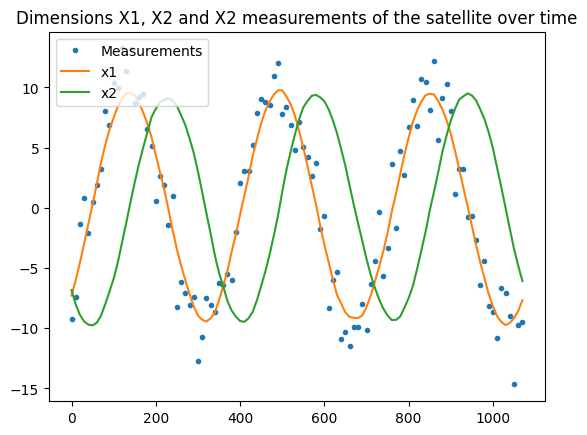

In [316]:
satellite.graph()

### $x_{1}$ Dimension
The real $x_{1}$ path vs the $x_{1}$ estimate path.\
The measurements and predictions are also included.

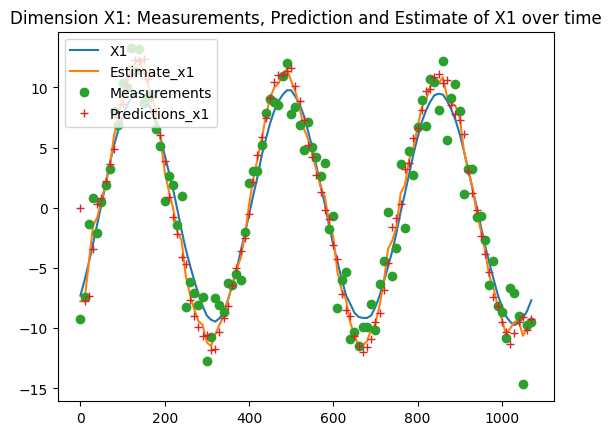

In [317]:
graph_x1(satellite, prediction_data, estimate_data)

### $x_{2}$ Dimension
The real $x_{2}$ path vs the $x_{2}$ estimate path. \
The predictions are also included.

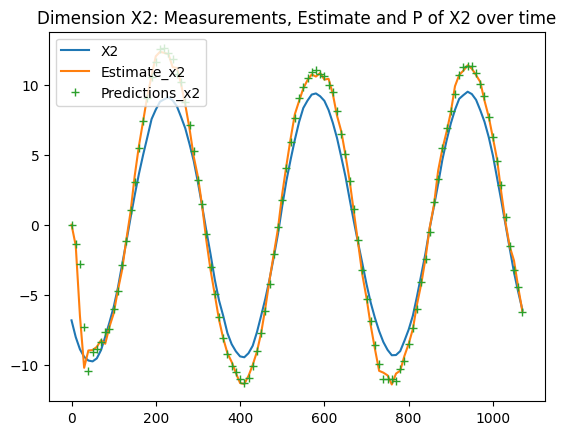

In [318]:
graph_x2(satellite, prediction_data, estimate_data)

### Error
Error of the $x_{1}$, $x_{2}$ Estimates\
Vs\
Error of the Measurements

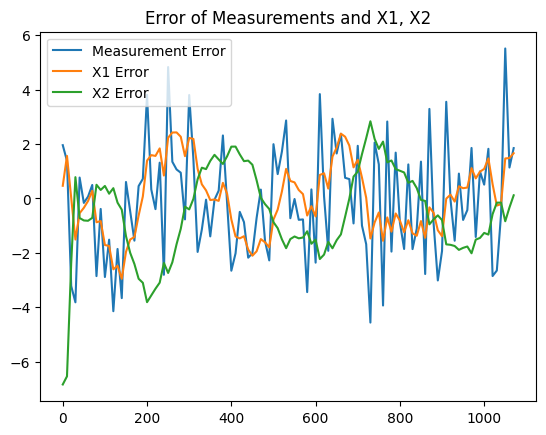

In [319]:
graph_error(satellite, prediction_data, estimate_data)

### Average Absolute Error
The average absolute error of the $x_{1}$, $x_{1}$ Estimates\
Vs\
The average absolute error of the Measurements

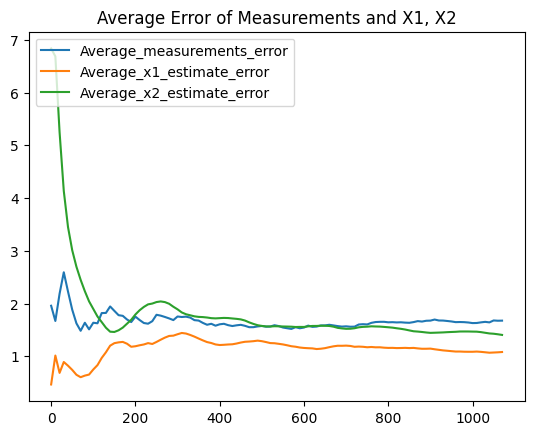

In [320]:
graph_average_error(satellite, prediction_data, estimate_data)

# Analysis

The current examples have used, \
Time step = 10\
Angle changed every time step = $\frac{2\pi}{360}$ \
Variance of the measurement noise = 2\
Variance of the satellite movement = 1\
Revolutions of the satellite = 3 \
\
To analyse the model. \
Create $10000$ satellite objects.\
For each one measure the absolute error of $x_1$, $x_2$ and measurement.\
Average the absolute error across the satellites and plot. \
Complete this for each different value of the variable changing.

In [321]:
analysis_satellites = 100
analysis_revolutions = 3

## Time step
Will analyse the time step being $5, 10, 20$ \
The first graph below is when $h=5$\
The second graph below is when $h=20$ \
You can see that there are far fewer measurements and they are more spread apart

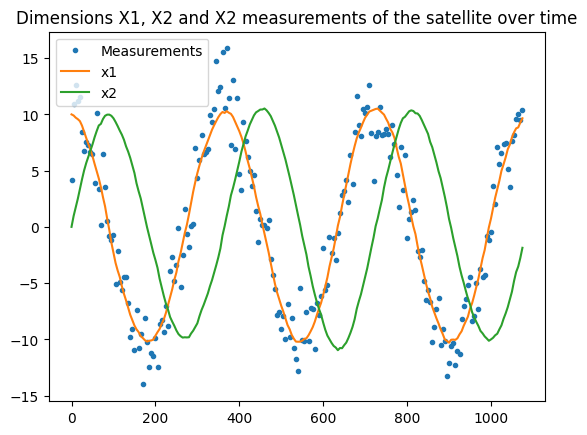

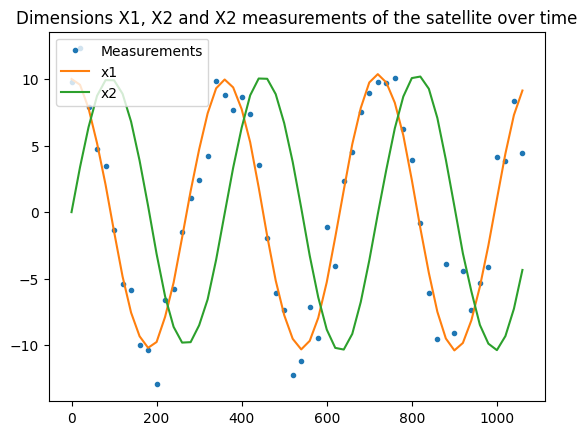

In [322]:
satellite_h_5 = satellite_example(5, a, r, q, radius, revolutions, receive_function, start_angle=0)
satellite_h_20 = satellite_example(20, a, r, q, radius, revolutions, receive_function, start_angle=0)
satellite_h_5[0].graph()
satellite_h_20[0].graph()

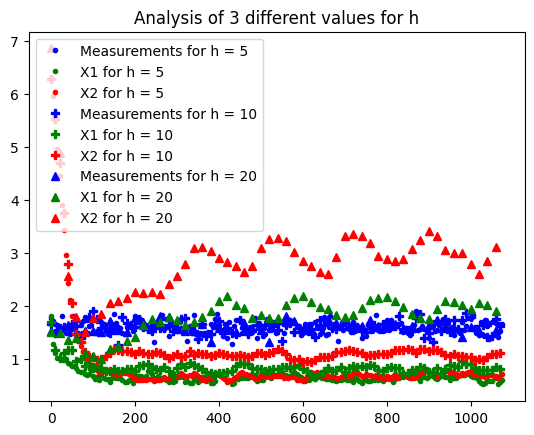

In [323]:
satellite_analysis(analysis_satellites, analysis_revolutions, 'h', [5, 10, 20])

### Time step Results
From the above graph can see that the model performs better than the measurements for time steps $5$ and $10$.\
However, the time step of $20$ is too large for the current model, and the model performs worse than the measurements.

## Variance of the Measurement Noise
Will analyse the Variance being $2, 4$ \
The first graph below is when $r=2$ \
The second graph below is when $r=4$ \
Increasing the variance of the measurement noise increases the average distance from the $x_1$ to the measurement of $x_1$

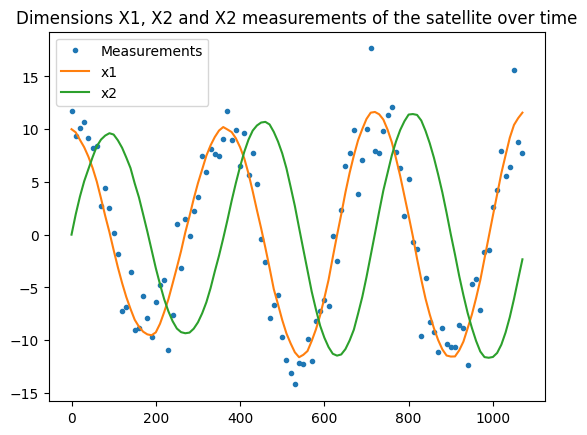

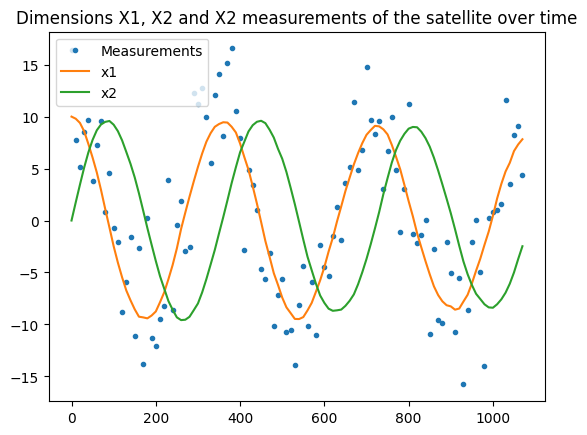

In [324]:
satellite_r_2 = satellite_example(h, a, 2, q, radius, revolutions, receive_function, start_angle=0)
satellite_r_4 = satellite_example(h, a, 4, q, radius, revolutions, receive_function, start_angle=0)
satellite_r_2[0].graph()
satellite_r_4[0].graph()

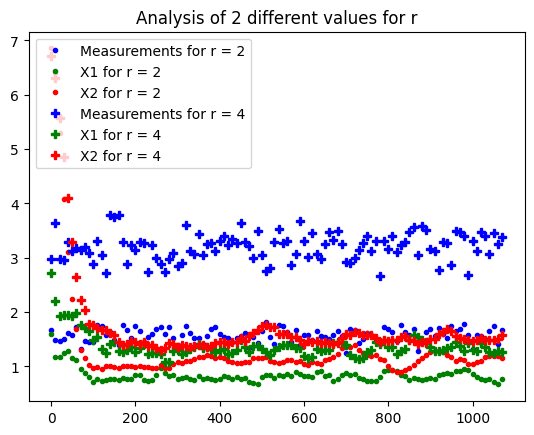

In [325]:
satellite_analysis(analysis_satellites, analysis_revolutions, 'r', [2, 4])

### Variance of the Measurement Noise Results
When $r=2$\
Measurement absolute error is around 1.7\
$x_1$ and $x_2$ are well below\
When $r=4$\
Measurement absolute error is around 3.2\
$x_1$ and $x_2$ are well below, at almost half
When the measurement noise is increased the model is able to perform better than the measurements.

## Variance of the satellite movement
Will analyse the Variance being $.05, 0.1, 0.2$ \
The first graph below is when $r=0.05$ \
The second graph below is when $r=0.2$ \
Increasing the variance of the satellite movement increases the number of random movements of the satellite

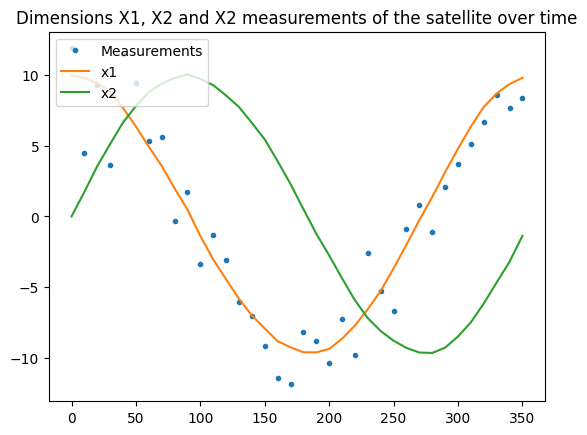

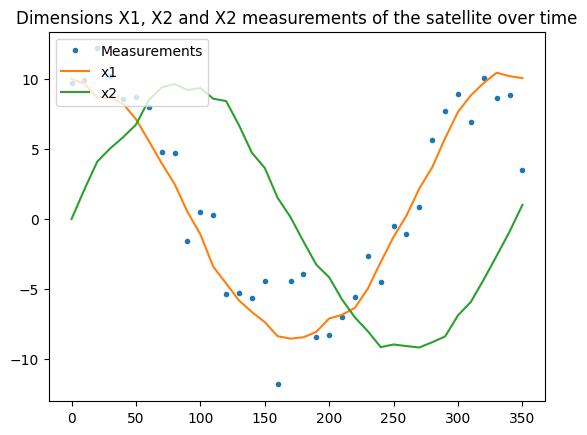

In [326]:
satellite_q_1 = satellite_example(h, a, r, .1, radius, 1, receive_function, start_angle=0)
satellite_q_4 = satellite_example(h, a, r, .4, radius, 1, receive_function, start_angle=0)
satellite_q_1[0].graph()
satellite_q_4[0].graph()

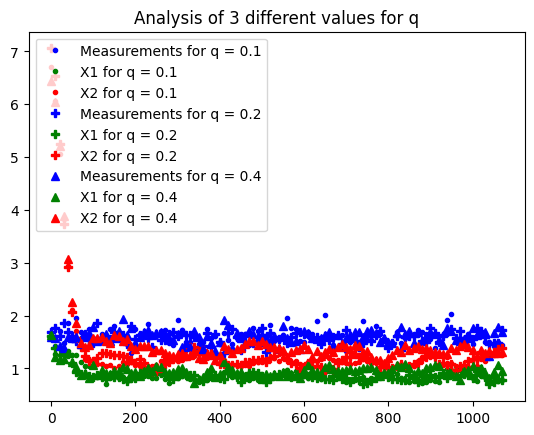

In [327]:
satellite_analysis(analysis_satellites, analysis_revolutions, 'q', [.1, .2, .4])

### Variance of the satellite movement Results
For all the values of q, $0.1, 0.2, 0.4$, the model performs better than the measurements.

# Unreliable observations of Measurements
It is not realistic to assume every $h$ seconds a new measurement will be available to use. \
Can change this, by changing the receive_function. \
If the functions returns $True$, a new measurement will be observed, the Kalman filter will continue as before. \
If the function returns $False$, the Kalman filter will run the predict step but not the update step.

## Create a Satellites with observations every second time step.
In the analysis of the time step, the observations were more accurate than the measurements for $h=20$. \
This will be satellite A. \
We will now create a second satellite with the time step to 10, $h=10$, and will observe a measurement every second time step. \
This will be satellite B. \
The satellites will behave the exact same, but the models will be different.

In [328]:
def every_second(i):
    return i % 2 == 0

satellite_h_20 = satellite_example(20, a, r, q, radius, revolutions, receive_function, start_angle=0) #Same as in the analysis of time step
satellite_h_10 = satellite_example(10, a, r, q, radius, revolutions, every_second, start_angle=0)

### Compare the two satellites
The first graph is satellite A. \
The second graph is satellites B. \
The graphs will be slightly different because of the random behavior of the satellites.

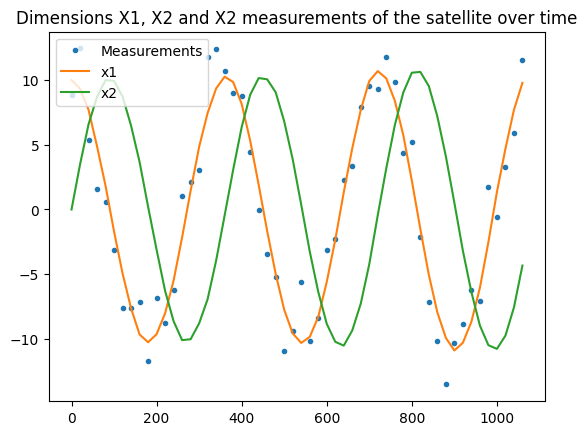

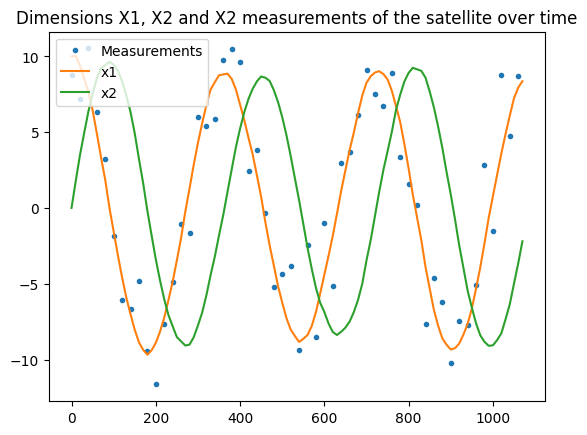

In [329]:
satellite_h_20[0].graph()
satellite_h_10[0].graph()

### Analysis of the satellites
The same analysis as in the analysis step, will be preformed for the two satellites.

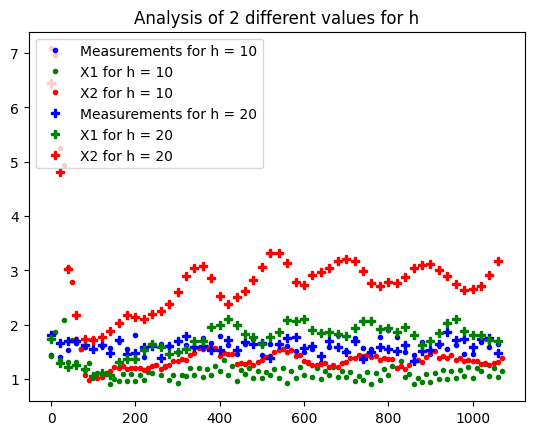

In [330]:
satellite_analysis(analysis_satellites, analysis_revolutions, 'h', [10, 20], receive_values=[every_second, always_true])

## Unreliable observations of Measurements Results
Satellite A behaviors the same as in the analysis step, preforming worse than the measurements.\
Satellite B preforms better than the measurements and significantly better that Satellite A. 
The small change in the model has lead to a significant increase in performance.
With more time the different time steps for this example for be explored and there performance measured and the optimal time step could be studied for a given time between measurements. Could use a time step of 2 and observe a measurement every 10 time steps, or a time step of 5 and observe a measurement every 4 steps ... for this example. 